# Creating a Workflow for Kaggle Titanic Comp

In this mission, we're going to explore a workflow to make competing in the [Kaggle Titanic competition](https://www.kaggle.com/c/titanic) easier, using a pipeline of functions to reduce the number of dimensions we need to focus on.

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [55]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Pre-processing the data

Start by loading previously written functions into the notebook.

In [56]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [57]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    cols = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
    for col in cols:
        df = create_dummies(df, col)
    
    return df

train = pre_process(train)
holdout = pre_process(holdout)

## Exploring the data

We will focus on the **SibSp** and **Parch** columns. 

- **sibsp**: # of siblings / spouses aboard the Titanic	
- **parch**: # of parents / children aboard the Titanic

The dataset defines family relations in this way...

- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [58]:
cols = ['SibSp', 'Parch']
train[cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


Both columns are numerical columns without any null values. 

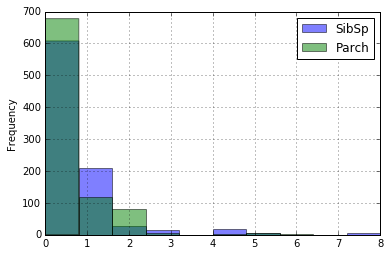

In [59]:
train[cols].plot.hist(alpha=0.5, bins=10)
plt.grid()

Both the columns have similar distributions - heavily skewed right and many zero values. 

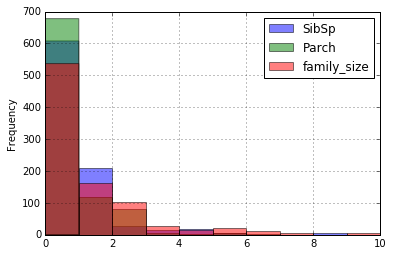

In [60]:
train['family_size'] = train[cols].sum(axis=1)
cols.append('family_size')
train[cols].plot.hist(alpha=.5, bins=10)
plt.grid()

Combining both the **sibsp** and **parch** columns we get a column of values representing the family size. This has a similar distribution to the seperate columns. 

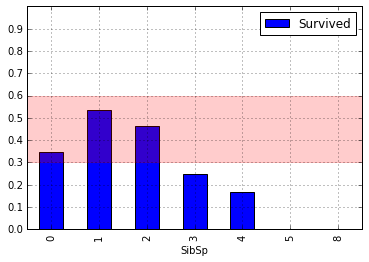

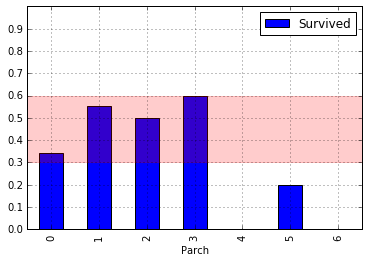

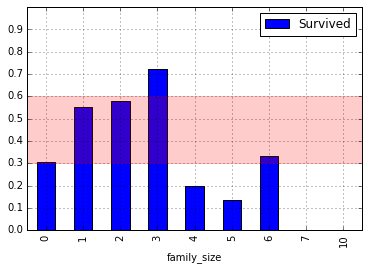

In [61]:
for col in cols:
    pivot = train.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.grid()
    plt.show()

We see the survival rate was highest for small families. Passengers with either no family or very large families was much lower. We see a survival rate of 30% for passengers without any family, and as low as 15% for familes with 5 members. 

## Engineering new features

Based on the analysis of family sizes, we can use a new feature for prediction - was the passenger alone. This will be a binary column containing the value:

- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

In [62]:
def add_isalone(df):
    df['family_size'] = df[['SibSp', 'Parch']].sum(axis=1)
    df['isalone'] = 0
    df.loc[df['family_size'] == 0, 'isalone'] = 1
    df = df.drop('family_size', axis=1)
    return df

train = add_isalone(train)
holdout = add_isalone(holdout)

## Selecting the best-performing features

Here we will automate selection of the best-performing features using recursive feature elimination.

In [64]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



## Model selection and tuning 

Next, we will build a function to handle the selection and tuning of different algorithms. The function we'll create will use three different algorithms and use grid search to train using different combinations of hyperparameters to find the best performing model.

We can achieve this by creating a list of dictionaries— that is, a list where each element of the list is a dictionary. Each dictionary should contain:

- The name of the particular model
- An estimator object for the model
- A dictionary of hyperparameters that we'll use for grid search.

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    models = [
        {
            'name': 'LogisticRegression',
            'estimator': LogisticRegression(),
            'hyperparameters':
                {
                    'solver': ['newton-cg', 'lbfgs', 'liblinear']
                }
        },
        {
            'name': 'KNeighborsClassifier',
            'estimator': KNeighborsClassifier(),
            'hyperparameters': 
                {
                    'n_neighbors': range(1, 20, 2),
                    'weights': ['distance', 'uniform'],
                    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                    'p': [1, 2]
                }
        },
        {
            'name': 'RandomForestClassifer',
            'estimator': RandomForestClassifier(),
            'hyperparameters':
                {
                    'n_estimators': [4, 6, 9],
                    'criterion': ['entropy', 'gini'],
                    'max_depth': [2, 5, 10], 
                    'max_features': ['log2', 'sqrt'],
                    'min_samples_leaf': [1, 5, 8],
                    'min_samples_split': [2, 3, 5]
                }
        }
    ]
    
    for mod in models:
        print(mod['name'])
        print('-'*len(mod['name']))
        
        grid = GridSearchCV(mod['estimator'], mod['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        
        mod["best_params"] = grid.best_params_
        mod["best_score"] = grid.best_score_
        mod["best_model"] = grid.best_estimator_
        
        print("Best Score: {}".format(mod["best_score"]))
        print("Best Parameters: {}\n".format(mod["best_params"]))

    return models

result = select_model(train, cols)

LogisticRegression
------------------
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------
Best Score: 0.7755331088664422
Best Parameters: {'weights': 'uniform', 'p': 1, 'algorithm': 'brute', 'n_neighbors': 5}

RandomForestClassifer
---------------------
Best Score: 0.8372615039281706
Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini', 'n_estimators': 9}



From this initial run, we see the Random Forest classifier return the highest accuracy at 83.7%.

## Making a submission

Finally, we can create a function to automate submissions with our best performing model, directly to Kaggle.

In [74]:
def save_submission_file(model, cols, filename='submission.csv'):
    holdout_data = holdout[cols]
    holdout_predictions = model.predict(holdout_data)
    
    submission_dict = {
        'PassengerID': holdout['PassengerId'],
        'Survived': holdout_predictions
    }
    
    submission = pd.DataFrame(submission_dict)
    submission.to_csv(filename, index=False)
    
best_model = result[2]['best_model']
save_submission_file(best_model, cols)

## Next steps...

Here are some potential next steps:

- Continue to explore the data and create new features
- Use some different algorithms in the select_model() function, like support vector machines, stochastic gradient descent or perceptron linear models.
- Experiment with RandomizedSearchCV instead of GridSearchCV to speed up select_features() function.